## Grape Leaf Disease Classification with ResNet50.


### Introduction

In this notebook, we'll fine-tune pre-trained ResNet50 model and use it to classify and predict grape leaf disease. ResNet50 is one of the State-Of-The-Art pre-trained CNN models that was trained on IMAGENET 1000 classes image dataset.

Let's dive in.

### Import necessary libraries

In [44]:
import os
import cv2
import PIL
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

This dataset was taken from this Kaggle link. https://www.kaggle.com/datasets/lavaman151/plantifydr-dataset

Here, we want to view a sample of our images. We'll use tf.keras image preprocessing library to load the image.

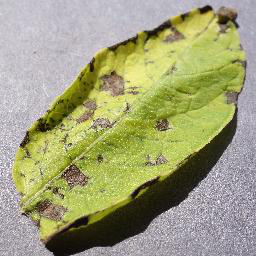

In [45]:
img1 =image.load_img('./Potato/train/Potato Early blight/PotatoEarlyBlight(4).JPG')
img1

Checking the image dimension with opencv imread.

In [46]:
cv2.imread('./Potato/train/Potato Early blight/PotatoEarlyBlight(4).JPG').shape

(256, 256, 3)

### Referencing our train and test data

In [47]:
train_dir ='./Potato/train/'
test_dir = './Potato/test'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

### Preprocess training image data.
Here, we'll load in our data using ImageDataGenerator Class in tensorflow. This allows us to rescale our images and split the data into train and validation data. It also loads our images in a specified batch size.

In [48]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )
val_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )  

In [49]:
train_set = train_gen.flow_from_directory(
    train_dir,
    subset = 'training',
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
)

Found 7589 images belonging to 3 classes.


In [50]:
val_set = train_gen.flow_from_directory(
    train_dir,
    subset = 'validation',
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
)

Found 1896 images belonging to 3 classes.


ImageDataGenerator infers the class labels from the directories name. We want to check the class labels.

​

In [51]:
train_set.class_indices

{'Potato Early blight': 0, 'Potato Healthy': 1, 'Potato Late blight': 2}

### Building the model.
First, we'll download the ResNet50 model from tensorflow keras applications that we imported earlier and store it in a variable.

We don't want to include the last layer because its trained to classify 1000 classes of images. Our data has only 2 classes.

We'll add more layers to the top of the model using the tensorflow keras sequential API.

### Freezing all the ResNet50 layers.
All the layers in ResNet50 are trainable by default. This means that we have to train all the layers completely from scratch. This will be a lot of computation. Using transfer learning, we want to retain the trained weights of the model and only train a few layers along with our added model layers.

In this case, we will set all layers to non-trainable.

In [52]:
# Instantiate a new sequential model

resnet_model = Sequential()

# Saving the downloaded ResNet50 model into a variable.

pretrained_model = tf.keras.applications.ResNet50(include_top = False,
                                                input_shape = (224,224,3),
                                                pooling = 'avg', 
                                                classes = 3,
                                                weights = 'imagenet'
                                                )

# Freezing all the layers.

for layer in pretrained_model.layers:
    layer.trainable = False


# Adding the pretrained ResNet50 model to the sequential model we instantiated above.

resnet_model.add(pretrained_model)

# Adding new layers to the top.

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation = 'relu'))
resnet_model.add(Dense(3, activation = 'softmax'))

In [53]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 1,050,627
Non-trainable params: 23,587,712
_________________________________________________________________


### Compile the model.

In [54]:
resnet_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
    )

We are now fitting the images into the model.

In [55]:


model_history = resnet_model.fit_generator(
     train_set,
     validation_data = val_set,
     epochs = 5,
     steps_per_epoch = len(train_set),
     validation_steps = len(val_set), 
     verbose = 1
)


C:\Users\Surface\AppData\Local\Temp\ipykernel_22084\790648634.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = resnet_model.fit_generator(


Epoch 1/5
475/475 [==============================] - 916s 2s/step - loss: 1.0610 - accuracy: 0.5114 - val_loss: 1.0301 - val_accuracy: 0.5390
Epoch 2/5
475/475 [==============================] - 848s 2s/step - loss: 1.0129 - accuracy: 0.5865 - val_loss: 0.9932 - val_accuracy: 0.5939
Epoch 3/5
475/475 [==============================] - 846s 2s/step - loss: 0.9815 - accuracy: 0.5926 - val_loss: 0.9634 - val_accuracy: 0.6007
Epoch 4/5
475/475 [==============================] - 891s 2s/step - loss: 0.9544 - accuracy: 0.5980 - val_loss: 0.9396 - val_accuracy: 0.6007
Epoch 5/5
475/475 [==============================] - 992s 2s/step - loss: 0.9306 - accuracy: 0.6056 - val_loss: 0.9155 - val_accuracy: 0.6076


In [56]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


We want to save our model for later use so that we don't have to train it all over again to save time

In [57]:
resnet_model.save('potato_resnet.h5')

### Preprocess test image data.
In the case of the test images, we'll only rescale the images and generate the batches

In [58]:

test_gen = ImageDataGenerator(rescale=1./255) 

test_set = test_gen.flow_from_directory(
    test_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
)

Found 25 images belonging to 3 classes.


### Plotting the accuracy and loss.

Here, we'll plot the accuracy and loss for both training and validation data.

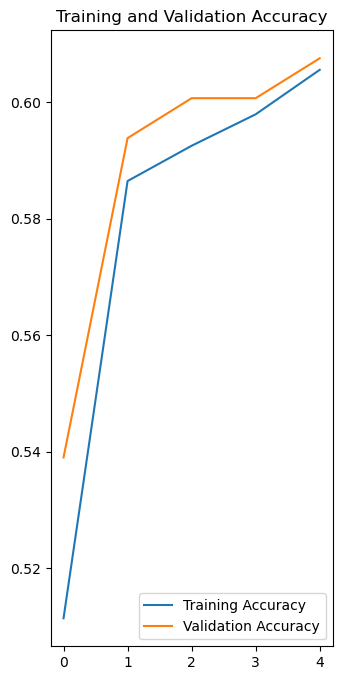

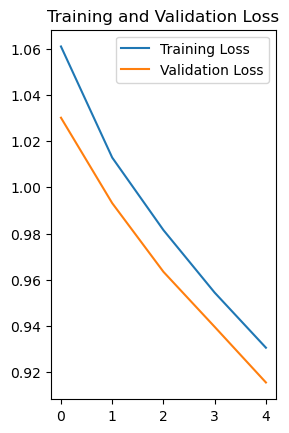

In [59]:
# plot the accuracy and loss
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(5), acc, label='Training Accuracy')
plt.plot(range(5), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


plt.subplot(1, 2, 2)
plt.plot(range(5), loss, label='Training Loss')
plt.plot(range(5), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Making predictions with test images.

In [60]:
predictions = resnet_model.predict(test_set, verbose=0)

In [61]:
cm = confusion_matrix(y_true=test_set.classes, y_pred=predictions.argmax(axis=1))
cm

array([[6, 0, 7],
       [2, 0, 0],
       [7, 0, 3]], dtype=int64)

In [62]:
test_set.class_indices

{'Potato Early blight': 0, 'Potato Healthy': 1, 'Potato Late blight': 2}

We want to evaluate our model's performance with the test images.

In [63]:
scores = resnet_model.evaluate(test_set, batch_size=16, verbose=2)

2/2 - 6s - loss: 1.1577 - accuracy: 0.5200 - 6s/epoch - 3s/step
